<a href="https://colab.research.google.com/github/DangKyAnh/Bai_Tap_AI_1/blob/main/Analizing_and_Predicting_Price_of_House.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import graphviz
from sklearn.tree import plot_tree, export_graphviz
from sklearn.tree import DecisionTreeRegressor  # Tinh toan model theo pp DecisionTreeRegressor
from sklearn import linear_model   
from sklearn.model_selection import train_test_split  # Phan chia data train vs test
from sklearn.linear_model import LinearRegression  # Tinh toan model theo pp LinearRegression
from sklearn.metrics import mean_squared_error   # Dua ra sai so model train
from sklearn.ensemble import RandomForestRegressor   # Tinh toan model theo pp RandomForestRegressor
from sklearn.model_selection import GridSearchCV     # Gia tang do chinh xac cua mo hinh 
import time  # Tinh toan thoi gian train cua model
import pickle  # Load file 


**Load data với file CSV**


In [ ]:
# Load data
url = r'/content/drive/MyDrive/AI/Final_Project/Data/housePrice.csv'
data = pd.read_csv(url)
data = pd.DataFrame(data)
data.head(10)

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33
5,70,2,True,True,False,North Program Organization,2.050000e+09,68333.33
6,87,2,True,True,True,Pardis,6.000000e+08,20000.00
7,59,1,True,True,True,Shahran,2.150000e+09,71666.67
8,54,2,True,True,False,Andisheh,4.930000e+08,16433.33
9,71,1,True,True,True,West Ferdows Boulevard,2.370000e+09,79000.00


**Tiền xử lí dữ liệu
Có 2 cột Price, nên xóa 1 cột chỉ giữ lại Price ở đơn vị USD** 

In [ ]:
# Xoa cot 'Price' va chen cac cot khac tien vao thay the
data.drop('Price', axis=1, inplace=True)

# Xu li kieu du lieu cua cac dac tinh (feature)
data['Area'] = data['Area'].str.replace(',', '').str.strip()  #Vì data có các giá trị bị lỗi có dấu phẩy nên phải bỏ dấu phẩy và chuyênnr nó thành int
data['Area'] = data['Area'].astype('int64')

data['Room'] = data['Room'].astype('int64')
data['Parking'] = data['Parking'].astype('int64')
data['Warehouse'] = data['Warehouse'].astype('int64')
data['Elevator'] = data['Elevator'].astype('int64')
data['Address'] = data['Address'].astype('string')
data['Price(USD)'] = data['Price(USD)'].astype('int64').round()

data.head(10)


,Area,Room,Parking,Warehouse,Elevator,Address,Price(USD)
0,63,1,1,1,1,Shahran,61666
1,60,1,1,1,1,Shahran,61666
2,79,2,1,1,1,Pardis,18333
3,95,2,1,1,1,Shahrake Qods,30083
4,123,2,1,1,1,Shahrake Gharb,233333
5,70,2,1,1,0,North Program Organization,68333
6,87,2,1,1,1,Pardis,20000
7,59,1,1,1,1,Shahran,71666
8,54,2,1,1,0,Andisheh,16433
9,71,1,1,1,1,West Ferdows Boulevard,79000


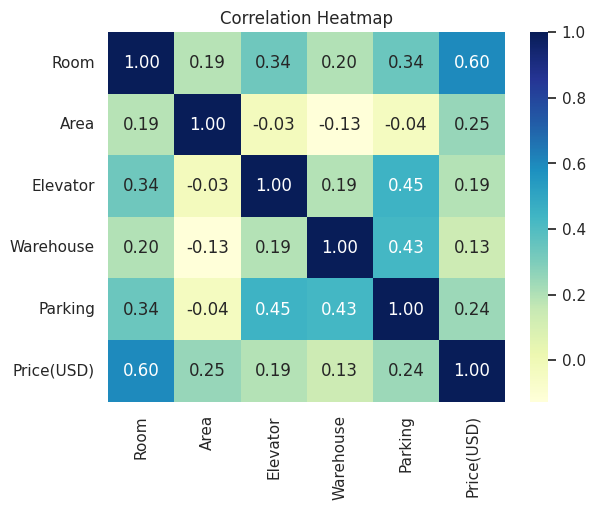

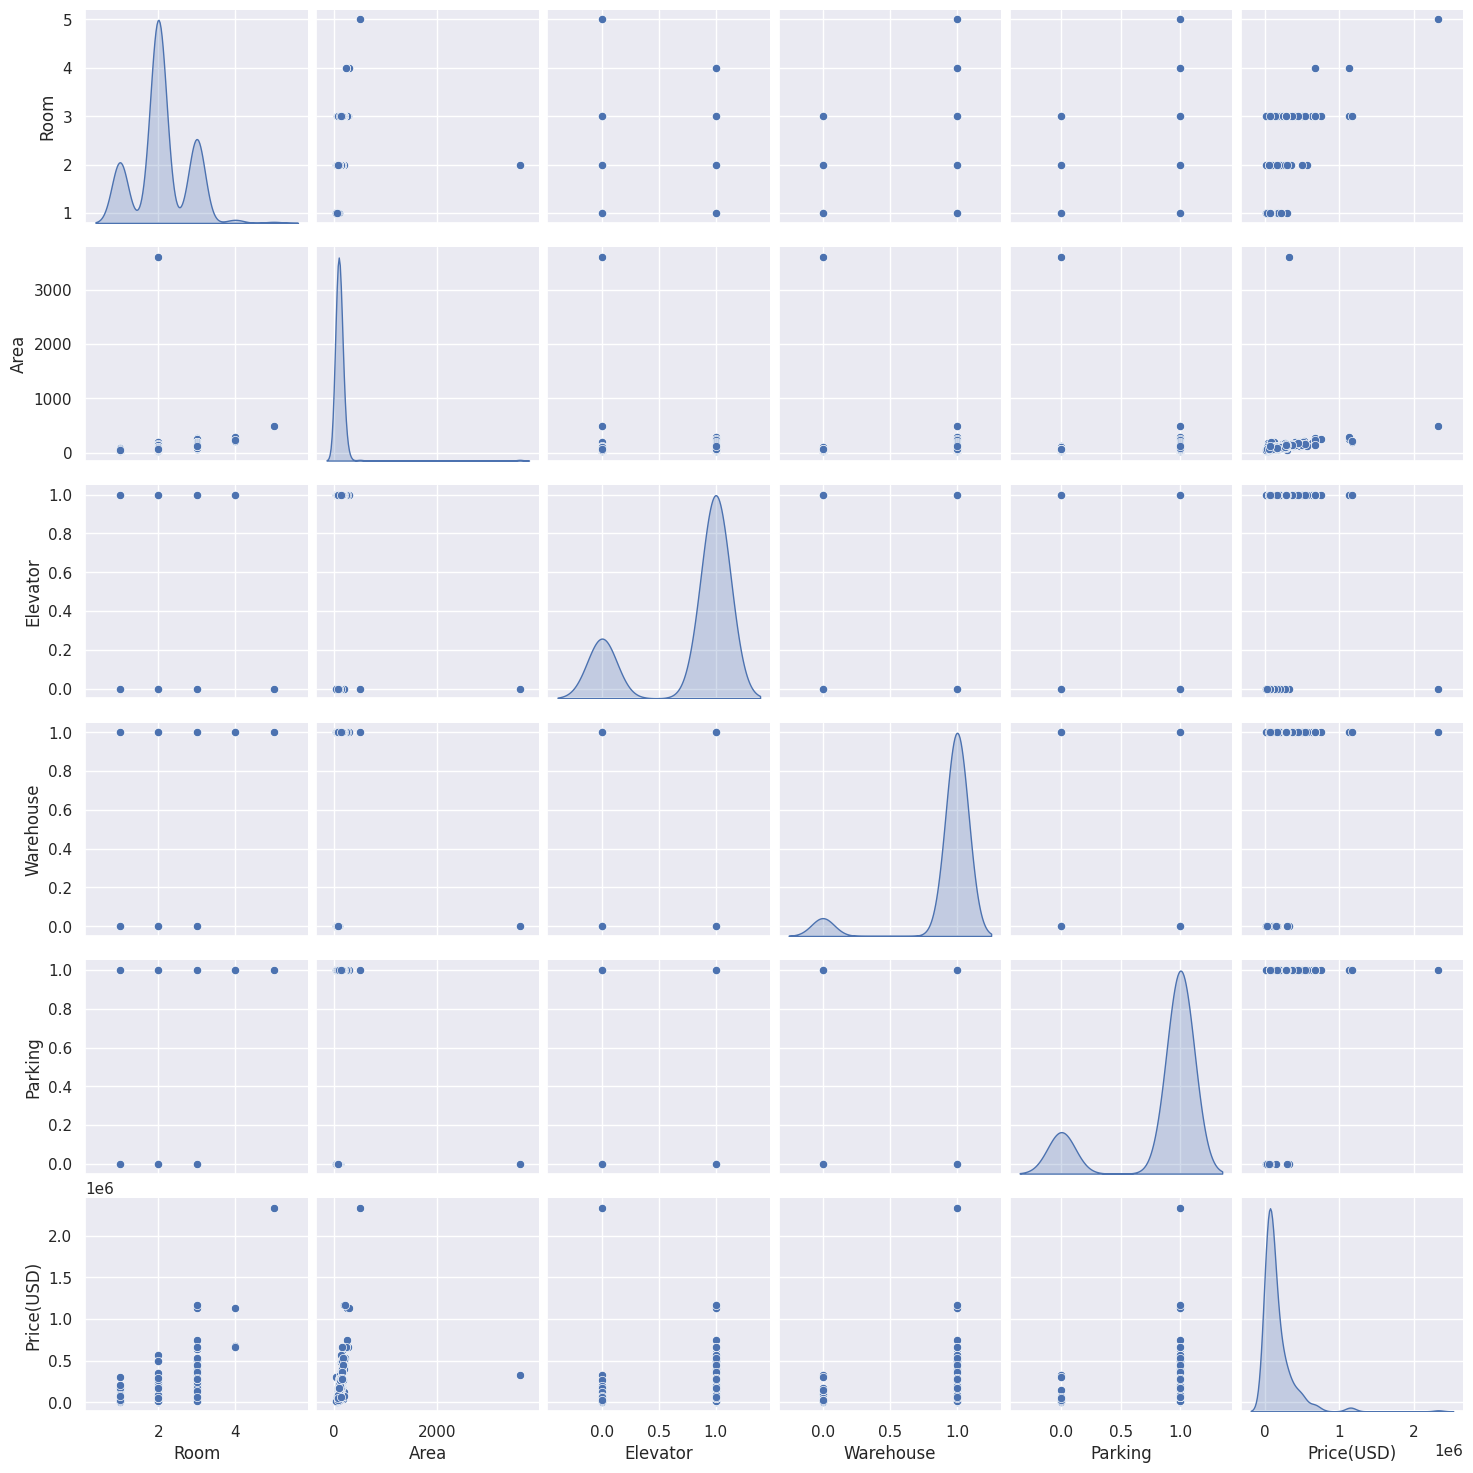

In [ ]:
# Subset the data
data_sub = data.sample(frac=0.1, random_state=42)

# Select a subset of variables
vars_to_analyze = [ 'Room', 'Area', 'Elevator', 'Warehouse', 'Parking', 'Price(USD)']
data_sub = data_sub[vars_to_analyze]

# Calculate correlations
corr = data_sub.corr()

# Plot heatmap
sns.set(font_scale=1)
sns.heatmap(corr, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Plot pairplot
sns.pairplot(data_sub, diag_kind='kde')
plt.show()

**Qua dữ liệu ta thấy:**

**1. Diện tích lớn nhất bất thường lên đến 1.6x10^10 m2**

**2. Số phòng bằng 0 là vô lý**

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,3479.0,8.744000e+06,3.167266e+08,30.0,69.0,90.0,120.0,1.616000e+10
Room,3479.0,2.079908e+00,7.582753e-01,0.0,2.0,2.0,2.0,5.000000e+00
Parking,3479.0,8.479448e-01,3.591260e-01,0.0,1.0,1.0,1.0,1.000000e+00
Warehouse,3479.0,9.146306e-01,2.794707e-01,0.0,1.0,1.0,1.0,1.000000e+00
Elevator,3479.0,7.872952e-01,4.092794e-01,0.0,1.0,1.0,1.0,1.000000e+00
Price(USD),3479.0,1.786338e+05,2.699978e+05,120.0,47275.0,96666.0,200000.0,3.080000e+06


**Xóa các đối tượng có số phòng bằng 0.**

**Hiển thị Room trên giảng đồ Histogram**

0


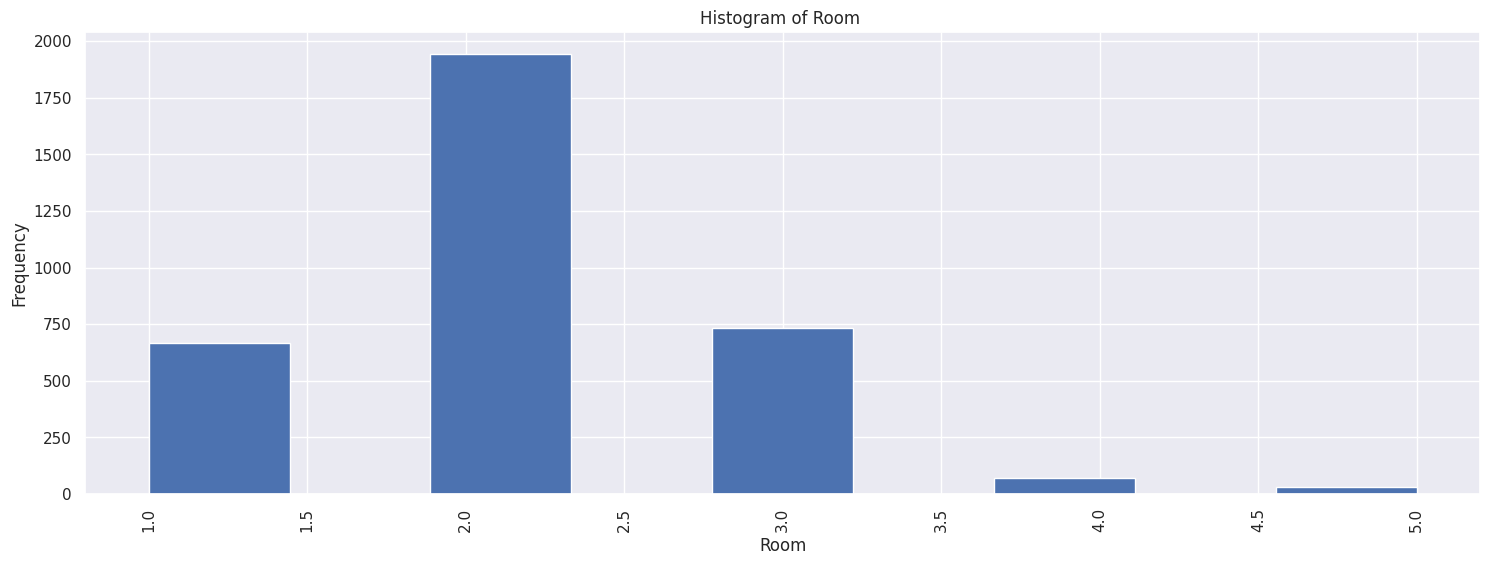

In [ ]:
# Xử lí các dữ liệu có số phòng băng 0
data['Room'].replace(0, np.nan, inplace = True)   # Thay the nhung gia tri cai ma so phong = 0, xoa bo
data.dropna(inplace=True)    # Xoa bo cac doi tuong khong co du lieu ( is null)
print((data['Room'] == 0).sum())  # Kiểm tra lại có còn tồn tại số phòng bằng 0 hay không

plt.figure(figsize=(18, 6))
data['Room'].hist(bins=9)
plt.xticks(rotation=90)
plt.xlabel('Room')
plt.ylabel('Frequency')
plt.title('Histogram of Room ')
plt.show()

**Xử lí dữ liệu về diện tích (Area)**

**Lọc dữ liệu. Chọn ra các diện tích mà giá trị của nó cao bắt thường. Ở đây chọn lọc ra các diện tích nhỏ hơn 800m2 để tăng độ chính xác của mô hình**

75.0     111
100.0    103
90.0      95
60.0      94
105.0     92
        ... 
228.0      1
177.0      1
221.0      1
287.0      1
256.0      1
Name: Area, Length: 201, dtype: int64


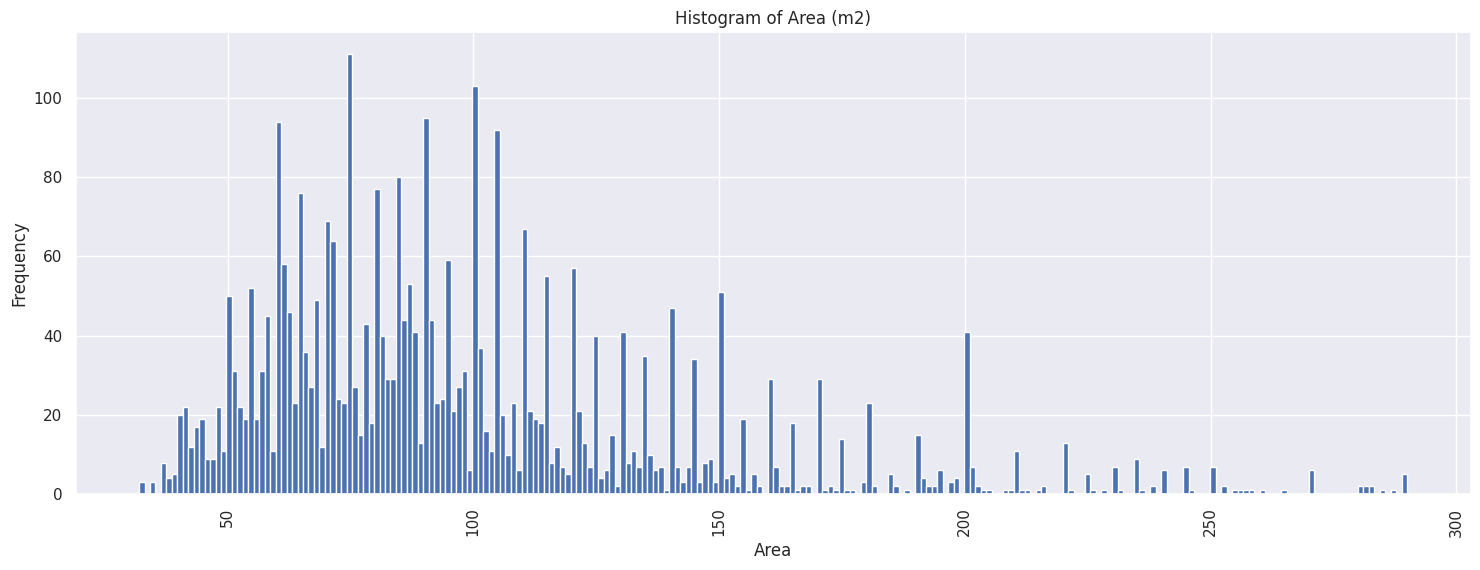

In [ ]:
# Xu li du lieu ve Area

data.loc[data['Area'] >= 300, 'Area'] = np.nan   # Xoa cac doi tuong co du lieu bat thuong, o day la lon hon 800
data.dropna(inplace=True) 

print(data['Area'].value_counts())   # In ra thong ke cac doi tuong
# print(data['Area'].unique())   # Dua ra tat ca cac feature cua doi tuong
# print(data.isnull().sum())    # In ra cac feature ma trong (khong co du lieu)

plt.figure(figsize=(18, 6))
data['Area'].hist(bins=232)
plt.xticks(rotation=90)
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.title('Histogram of Area (m2)')
plt.show()

**Hiển thị dữ liệu về Address để xử lí**

Punak                     161
Pardis                    146
West Ferdows Boulevard    145
Gheitarieh                137
Shahran                   130
                         ... 
Alborz Complex              1
Shadabad                    1
Naziabad                    1
Javadiyeh                   1
Yakhchiabad                 1
Name: Address, Length: 187, dtype: Int64
<StringArray>
[                   'Shahran',                     'Pardis',
              'Shahrake Qods',             'Shahrake Gharb',
 'North Program Organization',                   'Andisheh',
     'West Ferdows Boulevard',                     'Narmak',
                'Saadat Abad',                      'Zafar',
 ...
          'Thirteen November',                    'Darakeh',
              'Aliabad South',             'Alborz Complex',
                 'Firoozkooh',                  'Vahidiyeh',
                   'Shadabad',                   'Naziabad',
                  'Javadiyeh',                'Yakhchiabad']


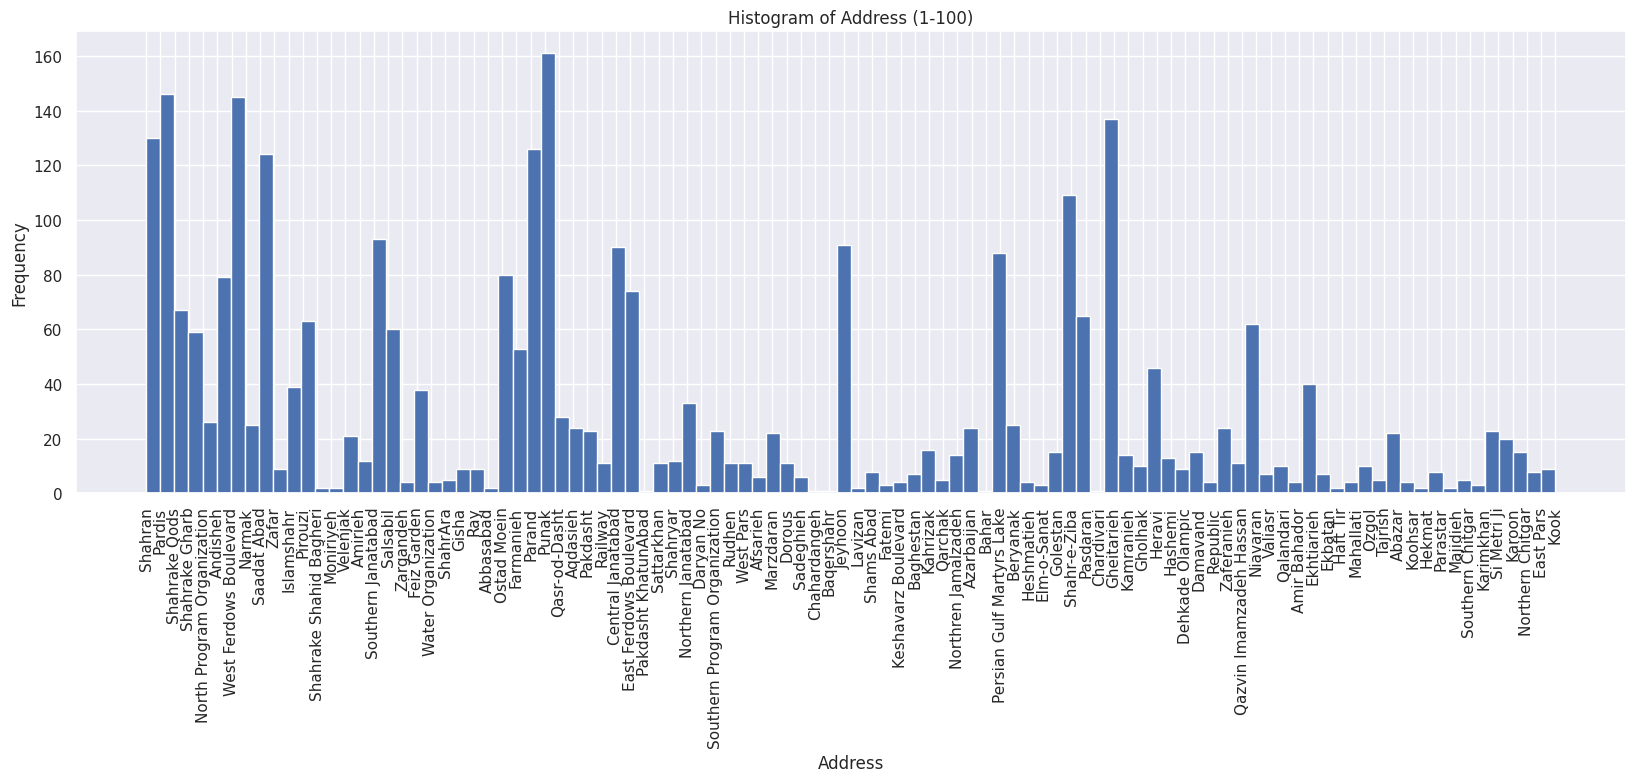

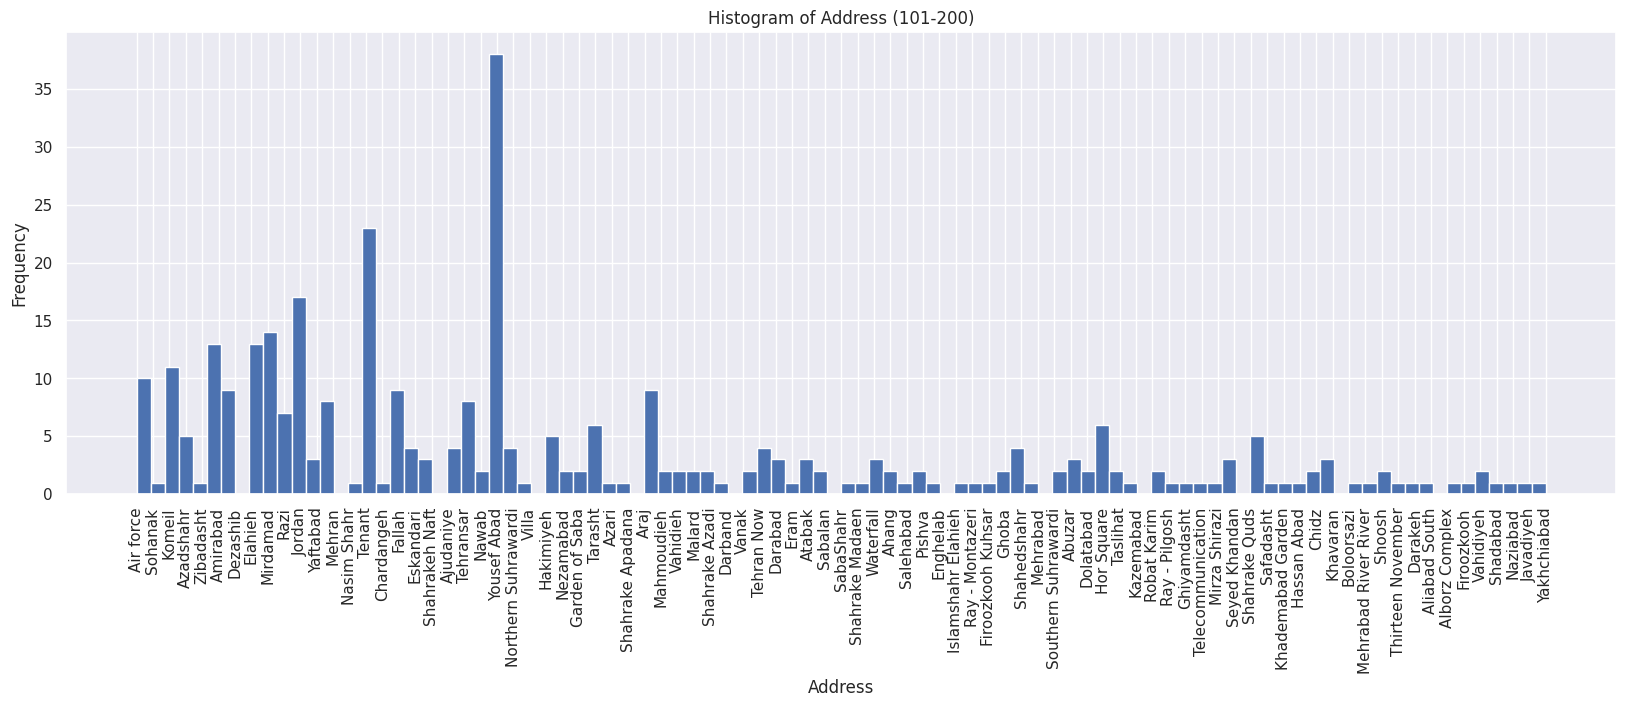

In [ ]:
# Display value counts of Address
print(data['Address'].value_counts())

# Display unique values of Address
print(data['Address'].unique())


# Filter data for addresses from 1 to 100
address_subset_1 = data[data['Address'].isin(data['Address'].unique()[:100])]

# Plot histogram for addresses from 1 to 100
plt.figure(figsize=(20, 6))
address_subset_1['Address'].hist(bins=100)
plt.xticks(rotation=90)
plt.xlabel('Address')
plt.ylabel('Frequency')
plt.title('Histogram of Address (1-100)')
plt.show()

# Filter data for addresses from 101 to 200
address_subset_2 = data[data['Address'].isin(data['Address'].unique()[100:200])]

# Plot histogram for addresses from 101 to 200
plt.figure(figsize=(20, 6))
address_subset_2['Address'].hist(bins=100)
plt.xticks(rotation=90)
plt.xlabel('Address')
plt.ylabel('Frequency')
plt.title('Histogram of Address (101-200)')
plt.show()


**Xử lí dữ liệu về địa chỉ (Address)**

**Lọc dữ liệu. Chọn ra các địa chỉ mà số lần lặp lại của nó lớn hơn 20 để tăng độ chính xác của mô hình**

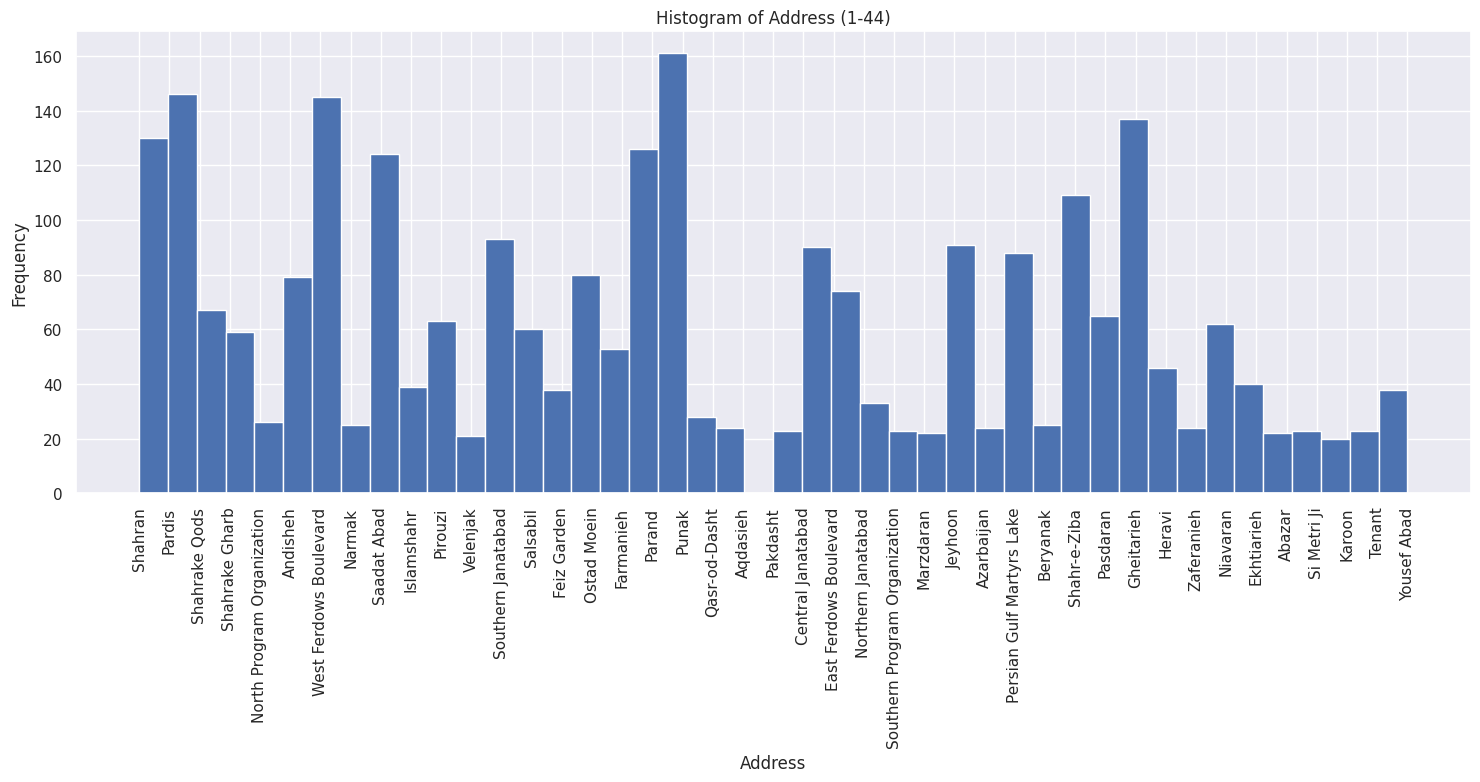

In [ ]:
# Hiển thị các Address và số lần xuất hiện
address_counts = data['Address'].value_counts()
#print(address_counts)

# Lọc ra các địa chỉ mà số lượng của nó quá ít. Ở đây ta chọn số lượng tối thiểu là 20
filter_address_01 = address_counts[address_counts >= 20].index

# Lọc data Address dựa vào điều kiện filter_address_01. Để xem xem data['Address'] 
# có thuộc các đối tượng có trong bộ lọc hay không nếu có thì nó gửi data. Và lưu lại thành tên khác filtered_data
filtered_data_01 = data[data['Address'].isin(filter_address_01)]

#print(filtered_data_01['Address'].describe())   # In ra thông tin của data vừa lọc, Và biết số lượng đối tượng giảm xuống còn 44

# Chọn ra chỉ hiển thị các Address có stt từ 0 đến 120
address_subset_1 = filtered_data_01[filtered_data_01['Address'].isin(filtered_data_01['Address'].unique()[:44])]

# Plot histogram for addresses from 1 to 44
plt.figure(figsize=(18, 6))
address_subset_1['Address'].hist(bins=44)
plt.xticks(rotation=90)
plt.xlabel('Address')
plt.ylabel('Frequency')
plt.title('Histogram of Address (1-44)')
plt.show()

In [ ]:
filtered_data_01.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2689 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        2689 non-null   float64
 1   Room        2689 non-null   float64
 2   Parking     2689 non-null   int64  
 3   Warehouse   2689 non-null   int64  
 4   Elevator    2689 non-null   int64  
 5   Address     2689 non-null   string 
 6   Price(USD)  2689 non-null   int64  
dtypes: float64(2), int64(4), string(1)
memory usage: 168.1 KB


**Tạo ID cho mỗi Address để train vì khi train không thể dùng kiểu string, nên convert mỗi Address thành một ID duy nhất** 

In [ ]:
# sáp nhập cột address mà mới vừa được lọc ở bên trên vào cái data gốc. Và đặt tên mới là data_filtered_02
data_filtered_02 = filtered_data_01.merge(filtered_data_01[['Address']], on='Address', how='inner')

data_filtered_02 = data_filtered_02.drop_duplicates()   # Xoa nhung doi tuong trung nhau

# Khởi tạo một cột trống tên là ['ID_Address']
data_filtered_02['ID_Address'] = ''

# Tạo ra một thư viện lưu lại các địa chỉ thành 1 sô ID thay vì là dạng string
address_dict = {address: str(i) for i, address in enumerate(data_filtered_02['Address'].unique())}

# Thêm các ID vào cột ID_Address 
data_filtered_02['ID_Address'] = data_filtered_02['Address'].replace(address_dict)
data_filtered_02['ID_Address'] = data_filtered_02['ID_Address'].astype('int64')

<ipython-input-188-38edcc976bcc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered_02['ID_Address'] = ''
<ipython-input-188-38edcc976bcc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered_02['ID_Address'] = data_filtered_02['Address'].replace(address_dict)
<ipython-input-188-38edcc976bcc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

**Bởi vì trong quá trình test ta chỉ nhập vào địa chỉ cho nên ta lưu địa chỉ và ID tương ứng vào một file riêng để có thể truy xuất tới ID**

In [ ]:
#Luu data Address thanh ID rieng 1 file

# Lấy các giá trị Address duy nhất 
unique_addresses = data_filtered_02['Address'].unique()
unique_id_addresses = data_filtered_02['ID_Address'].unique()

# Tạo DataFrame và lưu tuần tự từ ID tương ứng với mỗi Address
unique_values_df = pd.DataFrame({'Address': unique_addresses, 'ID_Address': unique_id_addresses})

# Lưu vào file csv
unique_values_df.to_csv('/content/drive/MyDrive/AI/Final_Project/Data/ID_Address_1.csv', index=False)

# Đọc file 
url = r'/content/drive/MyDrive/AI/Final_Project/Data/ID_Address.csv'
data_ID_Address = pd.read_csv(url)
data_ID_Address = pd.DataFrame(data_ID_Address)
print(data_ID_Address)

                          Address  ID_Address
0                         Shahran           0
1                          Pardis           1
2                   Shahrake Qods           2
3                  Shahrake Gharb           3
4      North Program Organization           4
5                        Andisheh           5
6          West Ferdows Boulevard           6
7                          Narmak           7
8                     Saadat Abad           8
9                      Islamshahr           9
10                        Pirouzi          10
11                       Velenjak          11
12             Southern Janatabad          12
13                       Salsabil          13
14                    Feiz Garden          14
15                    Ostad Moein          15
16                      Farmanieh          16
17                         Parand          17
18                          Punak          18
19                  Qasr-od-Dasht          19
20                       Aqdasieh 

**Kiểm tra xem số liệu của Price có bất thường không. Ta thấy được kể từ con số 1tr USD nó chỉ xuất hiện phân bố rất ít nên để tăng độ chính xác của mô hình train ta lọc các thông số từ 1tr USD**

Area   Room  Parking  Warehouse  Elevator  Address                     Price(USD)  ID_Address
170.0  2.0   1        1          1         Zaferanieh                  1066666     35            1
250.0  3.0   1        1          1         Niavaran                    1083333     36            1
290.0  4.0   1        1          1         Farmanieh                   1133333     16            1
       3.0   1        1          1         Farmanieh                   1233333     16            1
283.0  3.0   1        1          1         Farmanieh                   1128000     16            1
282.0  3.0   1        1          1         Farmanieh                   1222000     16            1
       2.0   1        1          1         Niavaran                    1000000     36            1
280.0  4.0   1        1          1         Velenjak                    1026666     11            1
                                           Saadat Abad                 1283333     8             1
270.0  4.0   1 

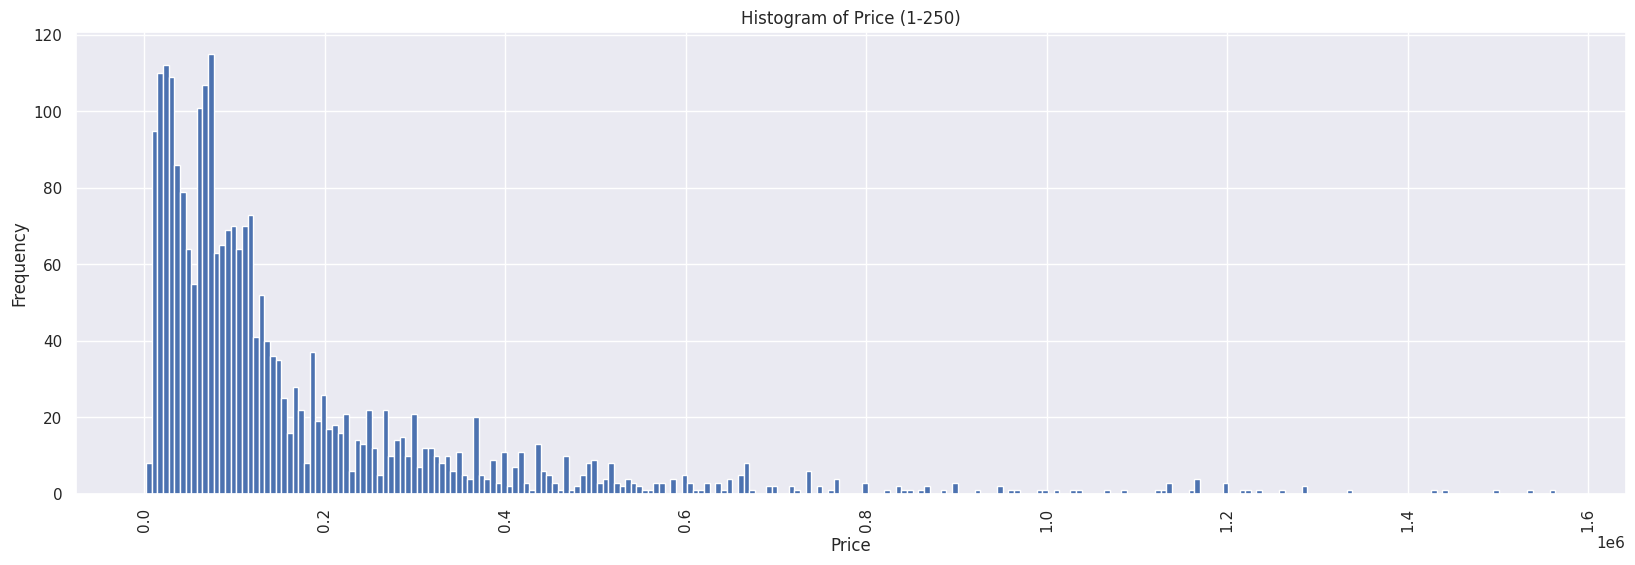

In [ ]:
print(data_filtered_02[data_filtered_02['Price(USD)'] >= 1000000].value_counts())

plt.figure(figsize=(20, 6))
data_filtered_02['Price(USD)'].hist(bins=250)
plt.xticks(rotation=90)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price (1-250)')
plt.show()

         Area  Room  Parking  Warehouse  Elevator      Address  Price(USD)  \
0        63.0   1.0        1          1         1      Shahran       61666   
130      60.0   1.0        1          1         1      Shahran       61666   
260      59.0   1.0        1          1         1      Shahran       71666   
390      65.0   1.0        1          1         1      Shahran       62666   
520      72.0   2.0        1          1         1      Shahran       78333   
...       ...   ...      ...        ...       ...          ...         ...   
241759  120.0   2.0        1          1         1  Yousef Abad      240000   
241797  150.0   3.0        1          1         1  Yousef Abad      366666   
241835  160.0   5.0        1          1         0  Yousef Abad      600000   
241873   55.0   2.0        0          1         0  Yousef Abad       71666   
241911  148.0   3.0        1          1         1  Yousef Abad      271333   

        ID_Address  
0                0  
130              0  


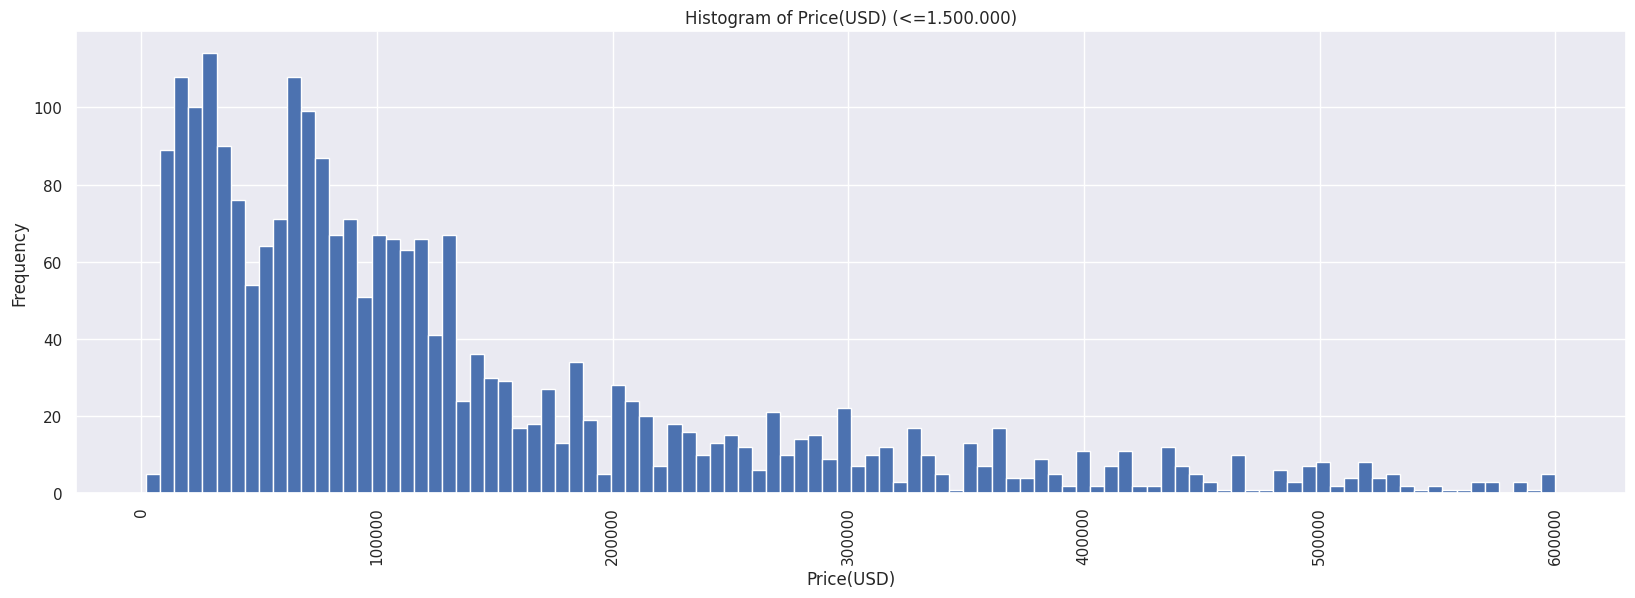

In [ ]:
# Filter data for selected addresses and Price(USD) <= 1500000
data_filtered_03 = data_filtered_02[(data_filtered_02['Price(USD)'] <= 600000)]

data_filtered_03 = data_filtered_03.drop_duplicates()   # Xoa nhung doi tuong trung nhau

# Print the resulting data
print(data_filtered_03)


print(data_filtered_03['Price(USD)'].value_counts())

# Plot histogram for Price(USD) <= 6000000
plt.figure(figsize=(20, 6))
data_filtered_03['Price(USD)'].hist(bins=100)
plt.xticks(rotation=90)
plt.xlabel('Price(USD)')
plt.ylabel('Frequency')
plt.title('Histogram of Price(USD) (<=1.500.000)')
plt.show()


In [ ]:
#Luu data Address thanh ID rieng 1 file

# Lấy các giá trị Address duy nhất 
unique_addresses = data_filtered_03['Address'].unique()
unique_id_addresses = data_filtered_03['ID_Address'].unique()

# Tạo DataFrame và lưu tuần tự từ ID tương ứng với mỗi Address
unique_values_df = pd.DataFrame({'Address': unique_addresses, 'ID_Address': unique_id_addresses})

# Lưu vào file csv
unique_values_df.to_csv('/content/drive/MyDrive/AI/Final_Project/Data/ID_Address_2.csv', index=False)

# Đọc file 
url = r'/content/drive/MyDrive/AI/Final_Project/Data/ID_Address_2.csv'
data_ID_Address = pd.read_csv(url)
data_ID_Address = pd.DataFrame(data_ID_Address)
print(data_ID_Address)

                          Address  ID_Address
0                         Shahran           0
1                          Pardis           1
2                   Shahrake Qods           2
3                  Shahrake Gharb           3
4      North Program Organization           4
5                        Andisheh           5
6          West Ferdows Boulevard           6
7                          Narmak           7
8                     Saadat Abad           8
9                      Islamshahr           9
10                        Pirouzi          10
11                       Velenjak          11
12             Southern Janatabad          12
13                       Salsabil          13
14                    Feiz Garden          14
15                    Ostad Moein          15
16                      Farmanieh          16
17                         Parand          17
18                          Punak          18
19                  Qasr-od-Dasht          19
20                       Aqdasieh 

In [ ]:
data_filtered_03.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,2406.0,94.593932,37.079093,33.0,67.0,87.0,113.0,290.0
Room,2406.0,2.008313,0.673784,1.0,2.0,2.0,2.0,5.0
Parking,2406.0,0.852452,0.354725,0.0,1.0,1.0,1.0,1.0
Warehouse,2406.0,0.925187,0.263144,0.0,1.0,1.0,1.0,1.0
Elevator,2406.0,0.795927,0.403106,0.0,1.0,1.0,1.0,1.0
Price(USD),2406.0,133715.816293,123803.957122,2000.0,46000.0,91833.0,175049.5,600000.0
ID_Address,2406.0,17.913134,12.095374,0.0,7.0,17.0,29.0,42.0


In [ ]:
# # Tạo DataFrame và lưu tuần tự từ ID tương ứng với mỗi Address
# unique_values_df_1 = pd.DataFrame(data_filtered_03)

# # Lưu vào file csv
# unique_values_df_1.to_csv('/content/drive/MyDrive/AI/Final_Project/Data/Test_Data_01.csv', index=False)

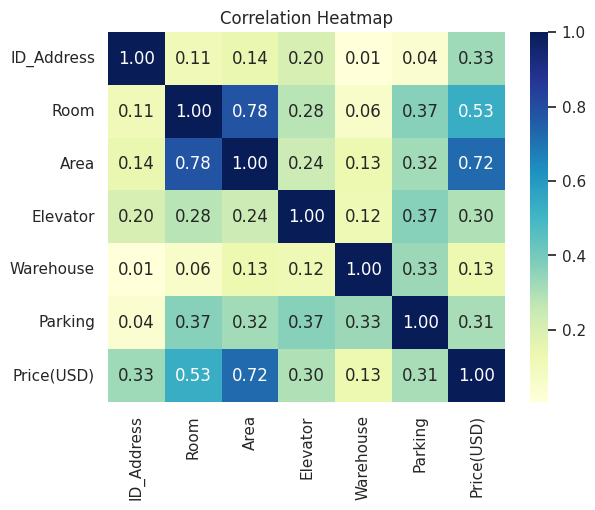

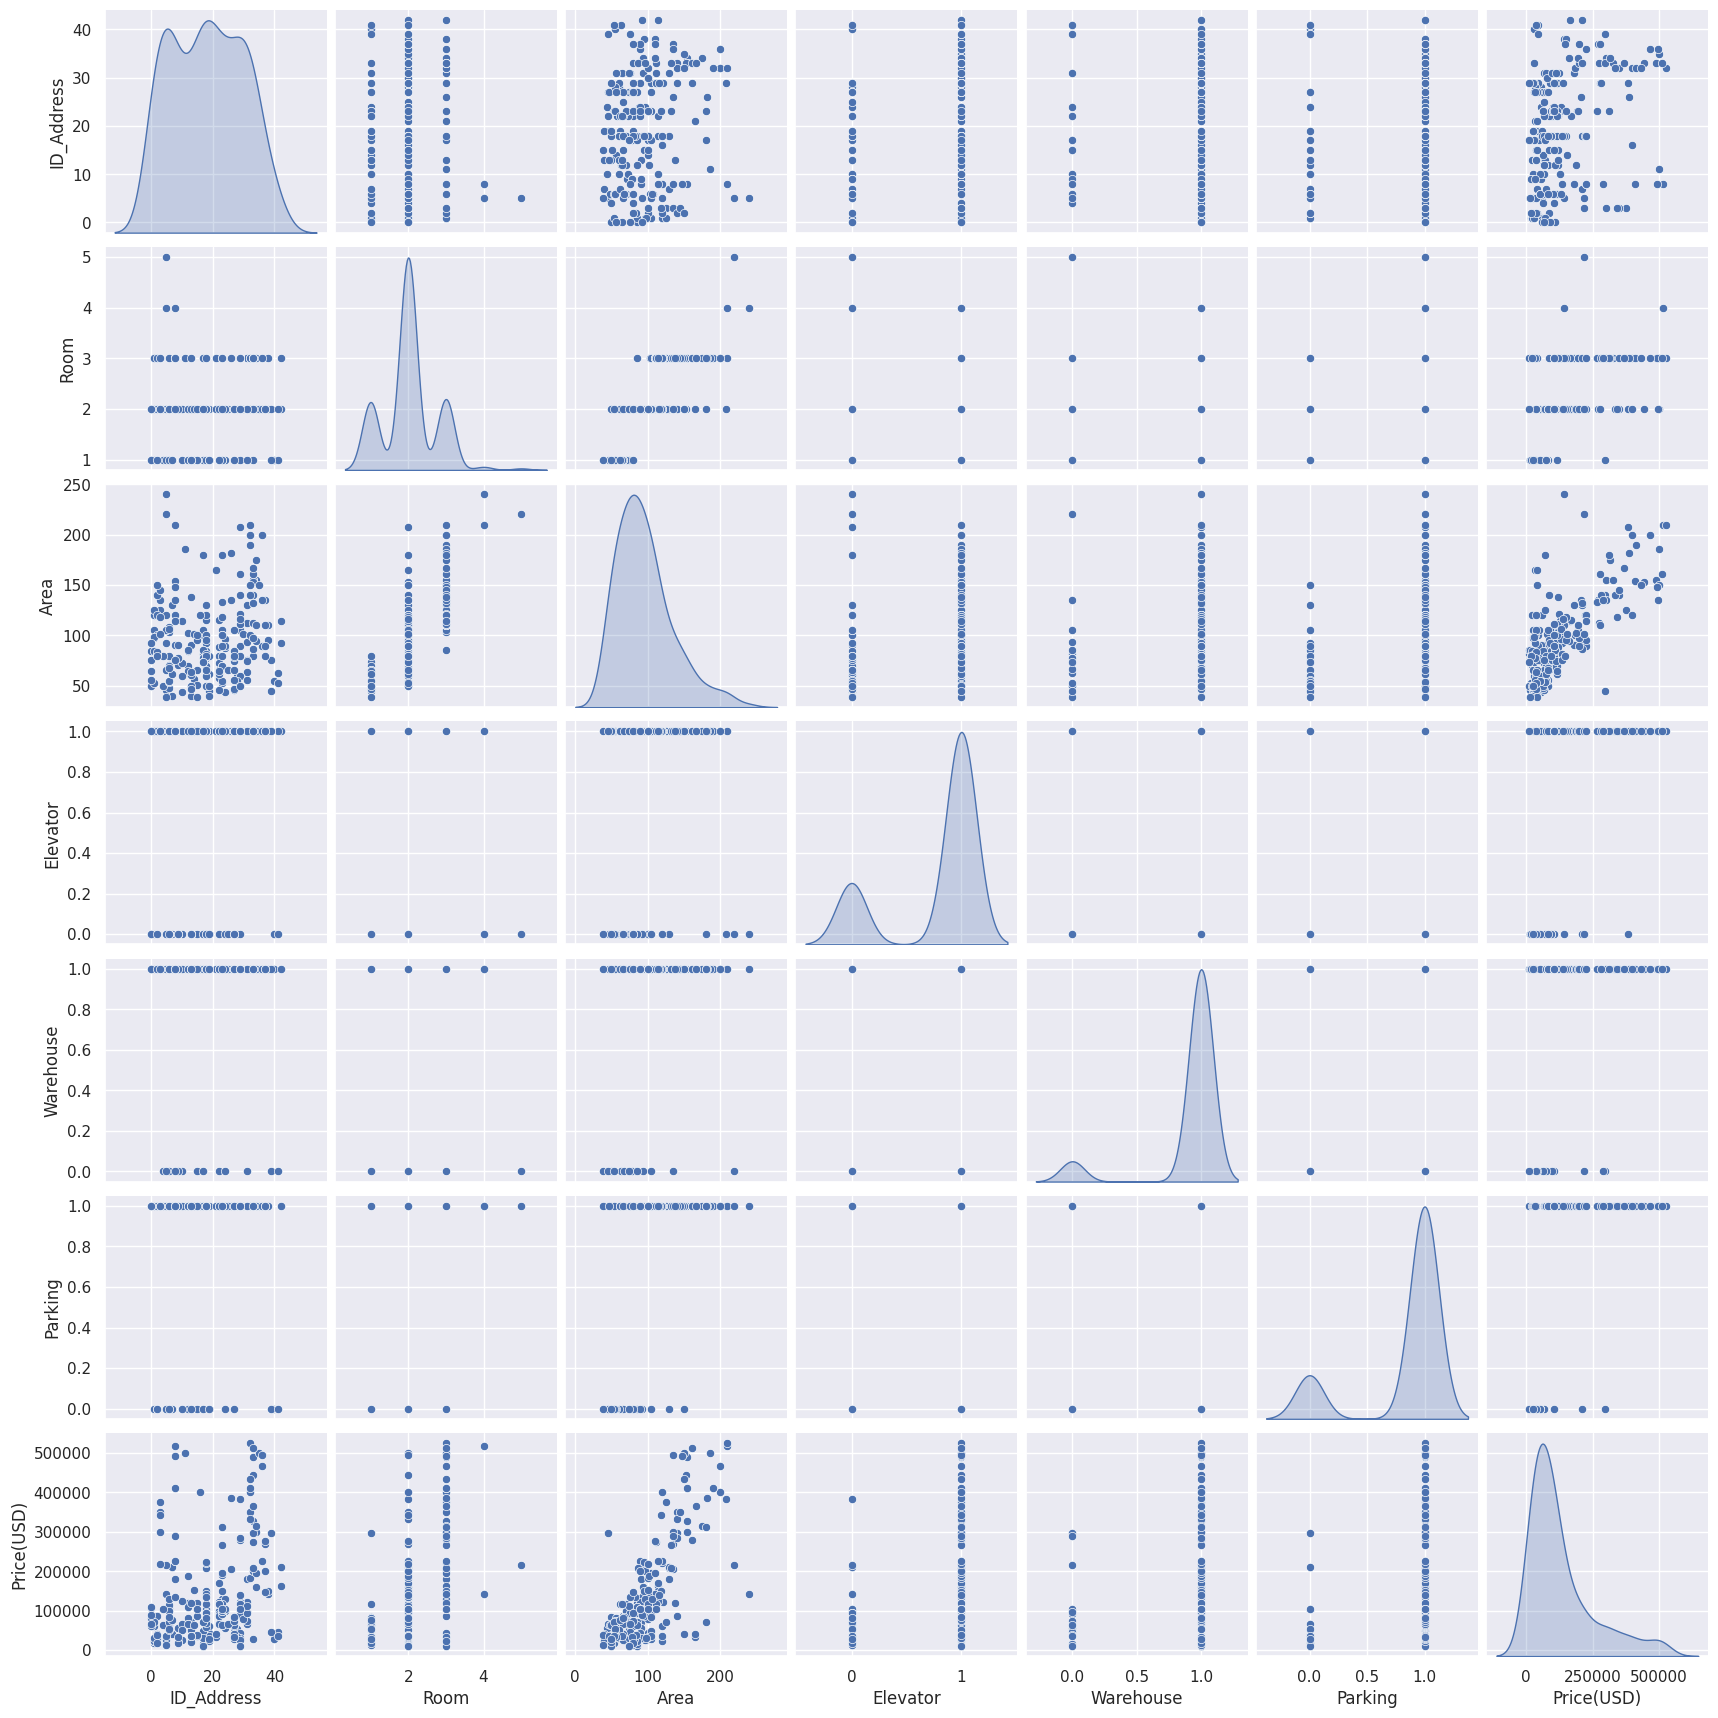

In [ ]:
# Subset the data
data_sub = data_filtered_03.sample(frac=0.1, random_state=42)

# Select a subset of variables
vars_to_analyze = [ 'ID_Address','Room', 'Area', 'Elevator', 'Warehouse', 'Parking', 'Price(USD)']
data_sub = data_sub[vars_to_analyze]

# Calculate correlations
corr = data_sub.corr()

# Plot heatmap
sns.set(font_scale=1)
sns.heatmap(corr, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Plot pairplot
sns.pairplot(data_sub, diag_kind='kde')
plt.show()

**Train Model**

Training Time: 0.61 seconds
Training RMSE: 26298.13
Testing RMSE: 53024.26
R-squared: 0.81


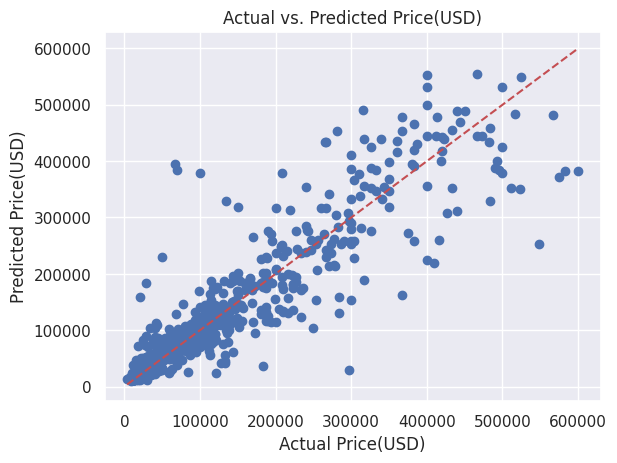

In [ ]:
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import pickle


# Select features and target variable
features = ['Room', 'Area', 'ID_Address']
target = 'Price(USD)'
X = data_filtered_03[features]
y = data_filtered_03[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reduce the size of the training data
sample_size = 5000  # Adjust the sample size as needed
X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=sample_size, random_state=42)

# Train the random forest model with reduced data
model = RandomForestRegressor(max_depth = 25)
start_time = time.time()
model.fit(X_train_sample, y_train_sample)
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Evaluate the model
y_train_pred = model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f"Training RMSE: {train_rmse:.2f}")

y_test_pred = model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Testing RMSE: {test_rmse:.2f}")

# Calculate R-squared value
r_squared = model.score(X_test, y_test)
print(f"R-squared: {r_squared:.2f}")

# Save the best model to a file
filename = '/content/drive/MyDrive/AI/Final_Project/Model/model_04.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)


y_test_pred = model.predict(X_test)

# Plot the predicted values against the actual values
plt.scatter(y_test, y_test_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Price(USD)')
plt.ylabel('Predicted Price(USD)')
plt.title('Actual vs. Predicted Price(USD)')
plt.show()

Training Time: 3.54 seconds
Training RMSE: 27793.96
Testing RMSE: 47097.13
R-squared: 0.86


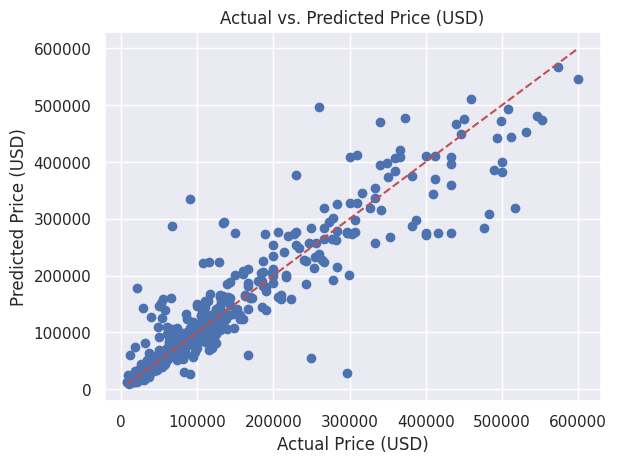

In [ ]:

#Model do chinh xac cao nhat 

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import time

start_time = time.time()

# Select features and target variable
features = ['Area', 'Room', 'ID_Address']
target = 'Price(USD)'
X = data_filtered_03[features]
y = data_filtered_03[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [15, 25],
    'n_estimators': [50, 100],
    'min_samples_split': [2, 3]
}

# Create the random forest regressor
model = RandomForestRegressor(random_state=42)

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Get the best model with optimized hyperparameters
best_model = grid_search.best_estimator_

# Evaluate the best model
y_train_pred = best_model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f"Training RMSE: {train_rmse:.2f}")

y_test_pred = best_model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Testing RMSE: {test_rmse:.2f}")

# Calculate R-squared value
r_squared = best_model.score(X_test, y_test)
print(f"R-squared: {r_squared:.2f}")

# Save the best model to a file
filename = '/content/drive/MyDrive/AI/Final_Project/Model/best_model_7.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)


# Plot the predicted values against the actual values
plt.scatter(y_test, y_test_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Price (USD)')
plt.ylabel('Predicted Price (USD)')
plt.title('Actual vs. Predicted Price (USD)')
plt.show()

Training RMSE: 36967.79
Testing RMSE: 48199.23
R-squared: 0.85


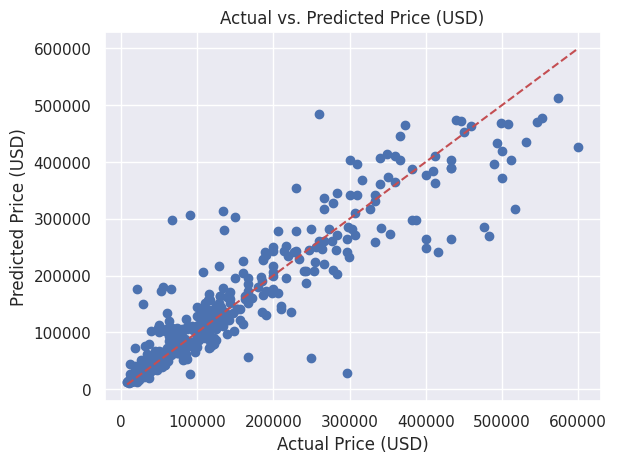

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Feature Engineering
# Add your feature engineering steps here

# Data Cleaning and Preprocessing
# Add your data cleaning and preprocessing steps here

# Select features and target variable
features = ['Area', 'Room', 'ID_Address']
target = 'Price(USD)'
X = data_filtered_03[features]
y = data_filtered_03[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Pipeline with feature scaling and model
pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=100))

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'randomforestregressor__max_depth': [15, 1000],
    'randomforestregressor__n_estimators': [100, 1000],
    'randomforestregressor__min_samples_split': [3, 10]
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model with optimized hyperparameters
best_model = grid_search.best_estimator_

# Evaluate the best model
y_train_pred = best_model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f"Training RMSE: {train_rmse:.2f}")

y_test_pred = best_model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Testing RMSE: {test_rmse:.2f}")

# Calculate R-squared value
r_squared = best_model.score(X_test, y_test)
print(f"R-squared: {r_squared:.2f}")

# Save the best model to a file
filename = '/content/drive/MyDrive/AI/Final_Project/Model/best_model_9.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

# Plot the predicted values against the actual values
plt.scatter(y_test, y_test_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Price (USD)')
plt.ylabel('Predicted Price (USD)')
plt.title('Actual vs. Predicted Price (USD)')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Load the data for ID_Address mapping
url = r'/content/drive/MyDrive/AI/Final_Project/Data/ID_Address_2.csv'
data_ID_Address = pd.read_csv(url)

# Load the saved model
filename = '/content/drive/MyDrive/AI/Final_Project/Model/best_model_7.pkl'
with open(filename, 'rb') as file:
    model = pickle.load(file)

print('Nhap dien tich cua phong: ')
Number_of_Area = input()
print('Nhap so phong: ')
Number_of_Room = input()
print('Nhap Address: ')
Address = input()

# Check if the Address input is in the ID_Address mapping data
if Address in data_ID_Address['Address'].values:
    # Get the corresponding ID_Address
    ID_Predict = data_ID_Address.loc[data_ID_Address['Address'] == Address, 'ID_Address'].iloc[0]

    print('ID Address: ' ,ID_Predict)

    # Create a new data point with input features
    new_data = [[Number_of_Area, Number_of_Room, ID_Predict]]  # Replace the values with your desired input

    # Make a prediction on the new data point
    prediction = model.predict(new_data)

    print("\nGia du doan cua ngoi nha la: ", prediction, ' USD')
else:
    print("Address not found in the mapping data.")


Nhap dien tich cua phong: 
68
Nhap so phong: 
2
Nhap Address: 
Southern Janatabad
ID Address:  12

Gia du doan cua ngoi nha la:  [69252.86247619]  USD


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
